# Detection and Classification of Military Planes: A Comparative Study of YOLO, Faster R-CNN, RetinaNet, and EfficientDet


---

In the midst of the ongoing war in Ukraine, the ability to accurately detect and classify military aircraft is of critical importance for surveillance, defense, and strategic planning. This capability can significantly contribute to national security and defense efforts.

With the availability of advanced models such as YOLO (You Only Look Once), Faster R-CNN, RetinaNet, and EfficientDet, the potential for higher accuracy and faster detection speeds has increased.

This project seeks to explore and compare the performance of these advanced models for the task of military aircraft detection and classification. By conducting this comparative study, I aim to identify the most suitable model for practical applications in military contexts.

I have decided to use a Military Aircraft Recognition dataset from Kaggle. This dataset includes 3842 images, 20 types, and 22341 instances annotated with horizontal bounding boxes and oriented bounding boxes.

In order to simplify the work, I have downloaded the entire dataset into my Git repository. Let's start by importing our project code and data from the Git repository:


In [ ]:
# Clone the repository
!git clone https://github.com/AndriyDragan/HawkEye.git

# Install YOLOv5
%pip install -U ultralytics

# Install TensorFlow Object Detection API dependencies
%pip install tensorflow tf_slim

# Clone the TensorFlow models repository
!git clone https://github.com/tensorflow/models.git

# Install additional dependencies
%cd models/research
%protoc object_detection/protos/*.proto --python_out=.
%pip install .
%pip install tensorflow-object-detection-api

# Data Analysis and Preparation

Let's start by importing the dependencies and examining the data:

In [2]:
import os
import time
import random
import math
import datetime
import itertools
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict, deque
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from transformers import FasterRCNNFeatureExtractor, FasterRCNNForObjectDetection
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as T
from torchvision.ops import box_iou
from torchvision.models.detection import fasterrcnn_resnet50_fpn, retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetHead
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from ultralytics import YOLO
from effdet import create_model, DetBenchTrain
from tqdm.notebook import tqdm


def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


data_dir = 'HawkEye/Data'

imfiles = os.listdir(os.path.join(data_dir, 'Images'))
imfiles = [os.path.join(data_dir, 'Images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpg']

def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)
print('Number of samples:', len(imfiles))
print('Image shape:      ', image.shape)

ImportError: cannot import name 'FasterRCNNFeatureExtractor' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

# Verifying Image Sizes
To ensure consistency, we'll check the dimensions of all images:

In [ ]:
# Dictionary to store the count of images for each shape
image_shapes = defaultdict(int)

for imfile in tqdm(imfiles):
    image = cv2.imread(imfile)
    if image is not None:
        shape = image.shape
        image_shapes[shape] += 1

# Iterate over all images and collect information about their shapes
for shape, count in image_shapes.items():
    print(f'Shape: {shape}, Count: {count}')

We observe a variety of image shapes. The main cluster is (800, 800, 3), which will be the base of our dataset.

# Reading Annotations

In [ ]:
# Function to read annotations
def read_annotations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
    return annotations


def read_data(file_names, data_dir):
    data = []
    labels = []
    dims = []

    for file_name in file_names:
        img_path = os.path.join(data_dir, 'Images', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Labels', 'Horizontal Bounding Boxes', file_name + '.xml')
        img = Image.open(img_path)

        if img.size != (800, 800):
            continue

        annotations = read_annotations(xml_path)

        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append((width, height))
            labels.append(annot[0])

        data.append((img_path, xml_path, (width, height)))

    return data, labels, dims

file_names = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'Images'))]
data, labels, dims = read_data(file_names, data_dir)


# Displaying Random Samples with Annotations
Let's display some random samples from our dataset with proper annotations:

In [ ]:
# Display random samples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax in axes:
    idx = np.random.randint(0, len(data) - 1)
    img_path, xml_path, _ = data[idx]
    img = Image.open(img_path)
    annotations = read_annotations(xml_path)
    draw = ImageDraw.Draw(img)

    for obj in annotations:
        label, (xmin, ymin, xmax, ymax) = obj
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        font_size = 20
        draw.text((xmax, ymin), label, fill='red')

    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

We will visualize additional properties of the dataset, such as per-class histogram and brightness distribution:

In [ ]:
# Compute and plot the per-class histogram
hist = Counter(labels)
plt.figure(figsize=(15, 5))
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram')
plt.show()

In [ ]:
# Print the per-class distribution
sorted_hist = dict(sorted(hist.items()))
for class_label, count in sorted_hist.items():
    print(f'Class {class_label}: {count} instances')

In [ ]:
# Sample a random subset of the dataset for brightness analysis
sample_size = 1000
sample_data_indices = np.random.choice(len(data), sample_size, replace=False)
brightness = []

for idx in sample_data_indices:
    img_path = data[idx][0]
    img = Image.open(img_path).convert('L')
    brightness.append(np.mean(np.array(img)))

sample_brightness = pd.DataFrame(brightness, columns=['Brightness'])

# Plot brightness distribution for the sample
plt.figure(figsize=(15, 5))
plt.hist(sample_brightness['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution (Sample)')
plt.show()

In [ ]:
# Brightness distribution per class for the sample
sample_labels = [labels[idx] for idx in sample_data_indices]
brightness_per_class = pd.DataFrame({'ClassId': sample_labels, 'Brightness': brightness}).groupby('ClassId')['Brightness'].mean()

plt.figure(figsize=(15, 5))
plt.bar(brightness_per_class.index, brightness_per_class.values)
plt.xlabel('Class Label')
plt.ylabel('Average Brightness')
plt.title('Average Brightness per Class (Sample)')
plt.grid(True)
plt.show()

I am a bit worried by severely unequal per-class distribution and would like to mitigate the risks of some classes undertraining. At first I decided that simplest pass would be to remove overepresented classes. Lets take maximum of 500 images of each class.

In [ ]:
# Counter to count instances of each class
def filter_data(data, class_counter, max_count):
    new_data = []
    new_class_counter = {class_name: 0 for class_name in class_counter}
    for img_path, xml_path, dimensions in data:
        annotations = read_annotations(xml_path)
        filtered_annotations = []
        for annot in annotations:
            class_name = annot[0]
            if new_class_counter[class_name] < max_count:
                filtered_annotations.append(annot)
                new_class_counter[class_name] += 1
        if filtered_annotations:
            new_data.append((img_path, xml_path, dimensions))
    return new_data

class_counter = Counter(labels)
max_count = 500
filtered_data = filter_data(data, class_counter, max_count)

# Update labels based on filtered_data
new_labels = []
for img_path, xml_path, dimensions in filtered_data:
    annotations = read_annotations(xml_path)
    for annot in annotations:
        new_labels.append(annot[0])

# Recount instances of each class in the new dataset
new_class_counter = Counter(new_labels)
sorted_new_class_counter = dict(sorted(new_class_counter.items()))

# Print new statistics
for class_label, count in sorted_new_class_counter.items():
    print(f'Class {class_label}: {count} instances')

In [ ]:
# Plot the updated per-class histogram
plt.figure(figsize=(15, 5))
plt.bar(sorted_new_class_counter.keys(), sorted_new_class_counter.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram After Filtering')
plt.show()

Yes I made my dataset much smaller yet I belive its optimal option to mitigate issues of class imbalance. I have no time to look for more data and using proper data augmentation is also out of scope of this project. But I will use pre-trained models and hope this data will be enough  for finetuning.

In [ ]:
# List of class names in the order of their class IDs
class_names = ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A2', 'A20', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']

# Split data into training and validation sets
random.shuffle(filtered_data)
split_index = int(0.8 * len(filtered_data))
train_data = filtered_data[:split_index]
val_data = filtered_data[split_index:]

# Write paths to image and XML annotation files
def write_data_to_file(data, file_path):
    with open(file_path, 'w') as f:
        for img_path, xml_path, _ in data:
            f.write(f"{img_path}\t{xml_path}\n")

# Use new file names for image-annotation pairs to avoid overwriting
write_data_to_file(train_data, os.path.join(data_dir, 'DataLists', 'train.txt'))
write_data_to_file(val_data, os.path.join(data_dir, 'DataLists', 'test.txt'))

# YOLO

In [ ]:
import shutil

# Function to parse XML and convert to YOLO format
def convert_xml_to_yolo(xml_path, img_size=(800, 800)):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_data = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        class_id = class_names.index(name)

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / img_size[0]
        y_center = (ymin + ymax) / 2 / img_size[1]
        width = (xmax - xmin) / img_size[0]
        height = (ymax - ymin) / img_size[1]

        yolo_data.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_data

# Function to copy files based on file path lists and convert labels
def copy_and_convert_files(file_list, img_dest, lbl_dest):
    with open(file_list, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                print(f"Skipping line due to unexpected format: {line}")
                continue
            img_path, xml_path = parts
            shutil.copy(img_path, img_dest)

            # Convert XML to YOLO and save
            yolo_data = convert_xml_to_yolo(xml_path)
            yolo_lbl_path = os.path.join(lbl_dest, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
            with open(yolo_lbl_path, 'w') as lbl_file:
                lbl_file.write("\n".join(yolo_data))

# Create directories for YOLO dataset
yolo_base_dir = '/content/datasets/dataset'
train_img_dir = os.path.join(yolo_base_dir, 'train/images')
train_lbl_dir = os.path.join(yolo_base_dir, 'train/labels')
val_img_dir = os.path.join(yolo_base_dir, 'val/images')
val_lbl_dir = os.path.join(yolo_base_dir, 'val/labels')

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# Copy and convert training and validation files
copy_and_convert_files(os.path.join(data_dir, 'DataLists', 'train.txt'), train_img_dir, train_lbl_dir)
copy_and_convert_files(os.path.join(data_dir, 'DataLists', 'test.txt'), val_img_dir, val_lbl_dir)

In [ ]:
# Create data.yaml with correct paths
data_yaml_content = f"""
train: {os.path.join(yolo_base_dir, 'train')}
val: {os.path.join(yolo_base_dir, 'val')}
nc: {len(set(labels))}
names: {list(set(labels))}
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [ ]:
# Train YOLO
yolo_model = YOLO('yolov5su.pt')

# Capture training history
yolo_model.train(data='data.yaml', epochs=10, imgsz=800)

# Validate YOLO
yolo_results = yolo_model.val()
print(yolo_results)


100%|██████████| 17.7M/17.7M [00:00<00:00, 139MB/s] 


Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 25.6MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              


  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1182720  ultralytics.nn.modules.block.C3              [512, 512, 1]                 
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    131584  ultralytics.nn.modules.conv.Conv             [512, 256, 1, 1]              
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    361984  ultralytics.nn.modules.block.C3              [512, 256, 1, False]          
 14                  -1  1     33024  ultralytics.nn.modules.conv.Conv             [256,

100%|██████████| 6.25M/6.25M [00:00<00:00, 111MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/dataset/train/labels... 1471 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1471/1471 [00:01<00:00, 1331.08it/s]


train: New cache created: /content/datasets/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/dataset/val/labels... 368 images, 0 backgrounds, 0 corrupt: 100%|██████████| 368/368 [00:00<00:00, 1168.86it/s]

val: New cache created: /content/datasets/dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.02G      1.252      3.503      1.242         85        800: 100%|██████████| 92/92 [00:26<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

                   all        368       2015      0.316      0.488      0.306       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      5.91G      1.032      2.192      1.075         88        800: 100%|██████████| 92/92 [00:21<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


                   all        368       2015      0.432      0.557      0.474      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.95G     0.9928      1.757      1.047        103        800: 100%|██████████| 92/92 [00:21<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]


                   all        368       2015      0.515      0.618      0.603      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.93G     0.9461      1.477      1.027         96        800: 100%|██████████| 92/92 [00:21<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]


                   all        368       2015      0.649      0.693      0.711       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.93G     0.9101      1.241      1.011         75        800: 100%|██████████| 92/92 [00:21<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]

                   all        368       2015      0.723      0.738      0.786      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.91G      0.899      1.071       1.01         72        800: 100%|██████████| 92/92 [00:21<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]

                   all        368       2015      0.809      0.796       0.86      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.91G     0.8578     0.9293     0.9891         62        800: 100%|██████████| 92/92 [00:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]

                   all        368       2015      0.777      0.812      0.864      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       5.9G     0.8358     0.8148     0.9866         63        800: 100%|██████████| 92/92 [00:21<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]

                   all        368       2015      0.815       0.87      0.901      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.92G      0.822     0.7431     0.9717         78        800: 100%|██████████| 92/92 [00:21<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]

                   all        368       2015      0.897      0.864      0.931      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.93G     0.7901     0.6603     0.9573         97        800: 100%|██████████| 92/92 [00:21<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.05it/s]

                   all        368       2015      0.906      0.904      0.949      0.764



10 epochs completed in 0.074 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv5s summary (fused): 193 layers, 9,119,276 parameters, 0 gradients, 23.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


                   all        368       2015      0.906      0.904      0.949      0.763
                   A14         28        136      0.795      0.829      0.874      0.716
                   A12         16         74      0.923      0.973      0.992      0.825
                    A2         40         97      0.922      0.907      0.946      0.764
                    A1         38        122      0.944      0.943      0.986      0.807
                   A11         22        110      0.974      0.818      0.961      0.684
                   A19         45        141      0.736      0.993       0.93      0.773
                   A10         22         78      0.852      0.872      0.911      0.711
                    A9         12         98      0.985      0.908      0.962      0.762
                    A7         50        165      0.976          1      0.995      0.812
                    A8         14         30      0.843      0.539        0.8      0.686
                   A1

val: Scanning /content/datasets/dataset/val/labels.cache... 368 images, 0 backgrounds, 0 corrupt: 100%|██████████| 368/368 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▊         | 2/23 [00:01<00:10,  1.93it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]


                   all        368       2015      0.905      0.899      0.945      0.759
                   A14         28        136      0.795      0.831      0.874      0.715
                   A12         16         74      0.923      0.973      0.992      0.828
                    A2         40         97       0.92      0.907      0.946      0.769
                    A1         38        122      0.944      0.943      0.986      0.806
                   A11         22        110      0.974      0.818      0.961      0.683
                   A19         45        141      0.737      0.993       0.93      0.772
                   A10         22         78       0.85      0.872       0.91      0.709
                    A9         12         98      0.985      0.908      0.962      0.759
                    A7         50        165      0.976      0.976      0.976      0.795
                    A8         14         30      0.844       0.54        0.8      0.675
                   A1

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


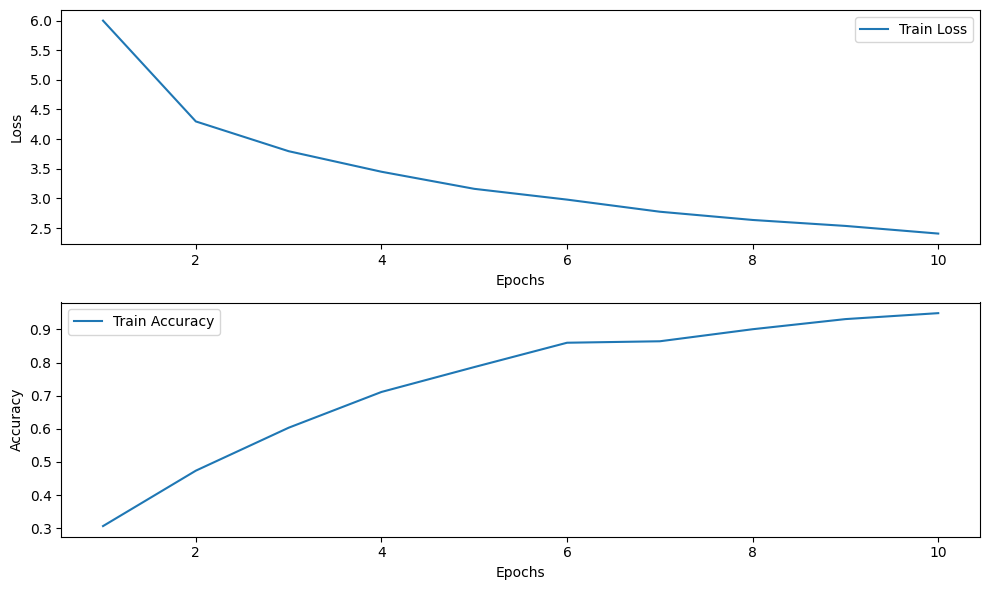

In [ ]:
# Load results.csv
results_file = 'runs/detect/train/results.csv'
df = pd.read_csv(results_file)

# Print column names to inspect them
print(df.columns)

# Strip leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Extract metrics using the stripped column names
epochs = df['epoch']
train_loss = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']
train_accuracy = df['metrics/mAP50(B)']  # Assuming mAP50 is used as a proxy for accuracy

# Plot metrics
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Set Up TensorFlow Object Detection API

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

# Define paths
WORKSPACE_PATH = os.path.join('Tensorflow', 'workspace')
SCRIPTS_PATH = os.path.join('Tensorflow', 'scripts')
APIMODEL_PATH = os.path.join('Tensorflow', 'models')
ANNOTATION_PATH = os.path.join(WORKSPACE_PATH, 'annotations')
IMAGE_PATH = os.path.join(WORKSPACE_PATH, 'images')
MODEL_PATH = os.path.join(WORKSPACE_PATH, 'models')
PRETRAINED_MODEL_PATH = os.path.join(WORKSPACE_PATH, 'pre-trained-models')
CONFIG_PATH = os.path.join(MODEL_PATH, 'my_ssd_mobnet', 'pipeline.config')
CHECKPOINT_PATH = os.path.join(MODEL_PATH, 'my_ssd_mobnet')

# Create necessary folders
!mkdir -p {ANNOTATION_PATH} {IMAGE_PATH} {MODEL_PATH} {PRETRAINED_MODEL_PATH}

# Copy the pre-trained model files from TensorFlow Model Zoo
!wget -P {PRETRAINED_MODEL_PATH} http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!wget -P {PRETRAINED_MODEL_PATH} http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_coco17_tpu-32.tar.gz
!wget -P {PRETRAINED_MODEL_PATH} http://download.tensorflow.org/models/object_detection/tf2/20200711/retinanet_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# Extract the models
!tar -zxvf {PRETRAINED_MODEL_PATH}/efficientdet_d0_coco17_tpu-32.tar.gz -C {PRETRAINED_MODEL_PATH}
!tar -zxvf {PRETRAINED_MODEL_PATH}/faster_rcnn_resnet50_coco17_tpu-32.tar.gz -C {PRETRAINED_MODEL_PATH}
!tar -zxvf {PRETRAINED_MODEL_PATH}/retinanet_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz -C {PRETRAINED_MODEL_PATH}

In [ ]:
# Set up the environment
%pip install tensorflow-gpu

Modify the Pipeline Configuration Files

In [ ]:
# Modify the configuration file
config_path = os.path.join(PRETRAINED_MODEL_PATH, 'efficientdet_d0_coco17_tpu-32', 'pipeline.config')
config = config_util.get_configs_from_pipeline_file(config_path)

# Update the number of classes
config['model']['ssd']['num_classes'] = len(class_names)

# Update fine_tune_checkpoint
config['train_config']['fine_tune_checkpoint'] = os.path.join(PRETRAINED_MODEL_PATH, 'efficientdet_d0_coco17_tpu-32', 'checkpoint', 'ckpt-0')

# Update label_map_path
config['train_input_reader']['label_map_path'] = os.path.join(ANNOTATION_PATH, 'label_map.pbtxt')
config['eval_input_reader']['label_map_path'] = os.path.join(ANNOTATION_PATH, 'label_map.pbtxt')

# Update the input paths
config['train_input_reader']['tf_record_input_reader']['input_path'] = [os.path.join(ANNOTATION_PATH, 'train.record')]
config['eval_input_reader']['tf_record_input_reader']['input_path'] = [os.path.join(ANNOTATION_PATH, 'val.record')]

# Save the modified pipeline config
config_util.save_pipeline_config(config, WORKSPACE_PATH)

# Faster R-CNN

In [ ]:
# Train Faster R-CNN
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={os.path.join(PRETRAINED_MODEL_PATH, 'faster_rcnn_resnet50_coco17_tpu-32', 'pipeline.config')} \
    --model_dir={os.path.join(MODEL_PATH, 'faster_rcnn')} \
    --alsologtostderr

# RetinaNet

In [ ]:
# Train RetinaNet
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={os.path.join(PRETRAINED_MODEL_PATH, 'retinanet_resnet50_v1_fpn_640x640_coco17_tpu-8', 'pipeline.config')} \
    --model_dir={os.path.join(MODEL_PATH, 'retinanet')} \
    --alsologtostderr

# EfficientDet

In [ ]:
# Train EfficientDet
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={os.path.join(PRETRAINED_MODEL_PATH, 'efficientdet_d0_coco17_tpu-32', 'pipeline.config')} \
    --model_dir={os.path.join(MODEL_PATH, 'efficientdet')} \
    --alsologtostderr

# Evaluation of the models

In [ ]:
# Evaluate Faster R-CNN
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={os.path.join(PRETRAINED_MODEL_PATH, 'faster_rcnn_resnet50_coco17_tpu-32', 'pipeline.config')} \
    --model_dir={os.path.join(MODEL_PATH, 'faster_rcnn')} \
    --checkpoint_dir={os.path.join(MODEL_PATH, 'faster_rcnn')} \
    --alsologtostderr \
    --eval_on_train_data

# Evaluate RetinaNet
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={os.path.join(PRETRAINED_MODEL_PATH, 'retinanet_resnet50_v1_fpn_640x640_coco17_tpu-8', 'pipeline.config')} \
    --model_dir={os.path.join(MODEL_PATH, 'retinanet')} \
    --checkpoint_dir={os.path.join(MODEL_PATH, 'retinanet')} \
    --alsologtostderr \
    --eval_on_train_data

# Evaluate EfficientDet
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={os.path.join(PRETRAINED_MODEL_PATH, 'efficientdet_d0_coco17_tpu-32', 'pipeline.config')} \
    --model_dir={os.path.join(MODEL_PATH, 'efficientdet')} \
    --checkpoint_dir={os.path.join(MODEL_PATH, 'efficientdet')} \
    --alsologtostderr \
    --eval_on_train_data

# Export the Trained Model for Inference

In [ ]:
# Export Faster R-CNN
!python models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path {os.path.join(PRETRAINED_MODEL_PATH, 'faster_rcnn_resnet50_coco17_tpu-32', 'pipeline.config')} \
    --trained_checkpoint_dir {os.path.join(MODEL_PATH, 'faster_rcnn')} \
    --output_directory {os.path.join(MODEL_PATH, 'exported_model/faster_rcnn')}

# Export RetinaNet
!python models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path {os.path.join(PRETRAINED_MODEL_PATH, 'retinanet_resnet50_v1_fpn_640x640_coco17_tpu-8', 'pipeline.config')} \
    --trained_checkpoint_dir {os.path.join(MODEL_PATH, 'retinanet')} \
    --output_directory {os.path.join(MODEL_PATH, 'exported_model/retinanet')}

# Export EfficientDet
!python models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path {os.path.join(PRETRAINED_MODEL_PATH, 'efficientdet_d0_coco17_tpu-32', 'pipeline.config')} \
    --trained_checkpoint_dir {os.path.join(MODEL_PATH, 'efficientdet')} \
    --output_directory {os.path.join(MODEL_PATH, 'exported_model/efficientdet')}

Conclusion